<a href="https://colab.research.google.com/github/dzafik/trading-backtest/blob/main/ijo_%2B_volume_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


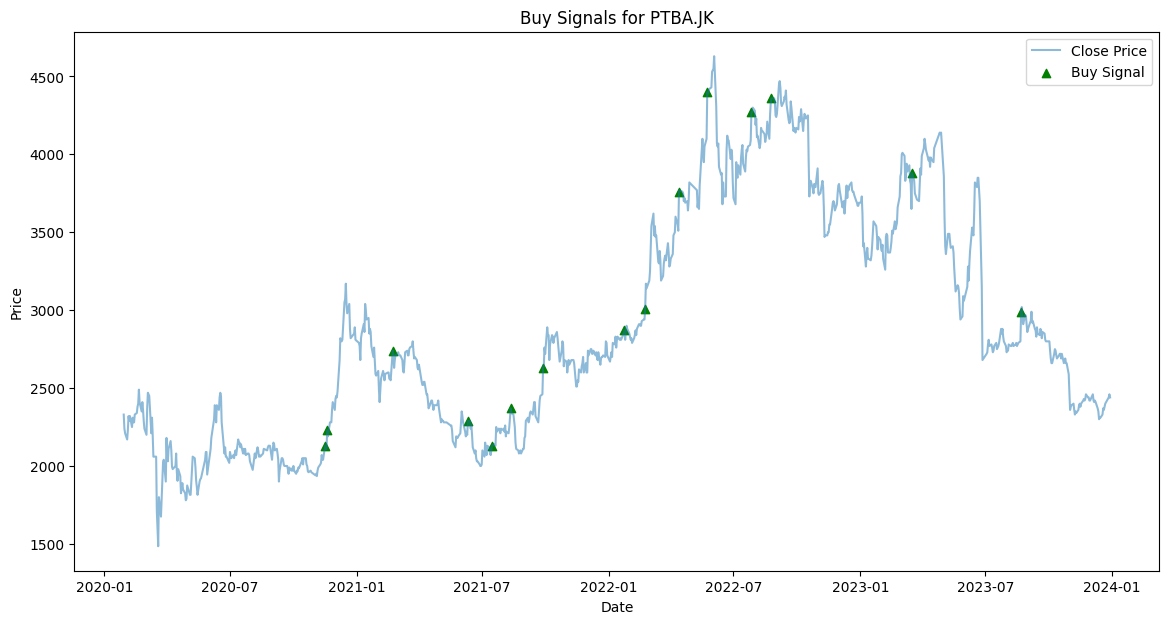

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk menghitung Simple Moving Average
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Fungsi untuk menghitung MACD dengan periode custom
def calculate_macd(data, short_period=8, long_period=13, signal_period=5):
    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Mengambil data saham dari Yahoo Finance
tickers = ['PTBA.JK']
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")

# Menghitung SMA (10) dan SMA (20)
data['SMA_10'] = calculate_sma(data, 10)
data['SMA_20'] = calculate_sma(data, 20)

# Menghitung MACD (8, 13, 5)
data['MACD'], data['Signal'] = calculate_macd(data)

# Membuat kolom MACD sebelumnya (shifted MACD)
data['Prev_MACD'] = data['MACD'].shift(1)

# Menghitung volume sebelumnya (shifted volume)
data['Prev_Volume'] = data['Volume'].shift(1)

# Menghitung RSI dan menambahkannya ke data
data['RSI'] = calculate_rsi(data)


# Kondisi entry
# Hanya mempertimbangkan data setelah SMA dan MACD tersedia (drop NA)
data.dropna(inplace=True)

# Definisi kondisi entry
def entry_condition(row):
    # Kriteria entry:
    # 1. Close > Open
    # 2. Current Price (Close) > SMA 10
    # 3. SMA 10 > SMA 20
    # 4. MACD saat ini > MACD sebelumnya
    # 5. Volume saat ini > 3 kali Volume sebelumnya
    # 6. Nilai transaksi > 1 miliar (Volume * Close)
    # 7. Harga >= 70S (70 rupiah dalam hal ini)
    # 8. RSI tidak boleh di atas 70 (tidak overbought)

    return (row['Close'] > row['Open'] and
            row['Close'] > row['SMA_10'] and
            row['SMA_10'] > row['SMA_20'] and
             row['MACD'] > row['Prev_MACD'] and  # Menggunakan Prev_MACD untuk perbandingan
            row['Volume'] > 3 * row['Prev_Volume'] and
            (row['Volume'] * row['Close']) > 1e9 and
            row['Close'] >= 70) #and
            #row['RSI'] < 70)

# Menerapkan kondisi entry
data['Buy_Signal'] = data.apply(entry_condition, axis=1)

# Plotting sinyal beli
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.5)

# Ambil index dari sinyal beli
buy_signal_dates = data.index[data['Buy_Signal']]
buy_signal_prices = data['Close'][data['Buy_Signal']]

# Scatter plot untuk sinyal beli
plt.scatter(buy_signal_dates, buy_signal_prices, color='green', label='Buy Signal', marker='^', alpha=1)

plt.title(f"Buy Signals for {tickers[0]}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
